In [3]:
using FourierFlows, PyPlot
using LinearAlgebra: mul!, ldiv!
parsevalsum = FourierFlows.parsevalsum

┌ Info: Precompiling FourierFlows [2aec4490-903f-5c70-9b11-9bed06a700e1]
└ @ Base loading.jl:1278
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


parsevalsum (generic function with 1 method)

$$N = - \widehat{𝖩(ψ, ζ)} = - i k_x \widehat{u ζ} - i k_y \widehat{v ζ}$$

In [4]:
function Problem(dev::Device=CPU();
  # Numerical parameters
                nx = 64,
                ny = nx,
                nz = nx,
                Lx = 2π,
                Ly = Lx,
                Lz = Lx,
   # Drag and/or hyper-viscosity for velocity/B-field
                 ν = 0,
                nν = 1,
                 μ = 0,
                 η = 0,
                nμ = 0,
  # Timestepper and equation options
                dt = 0.01,
           stepper = "RK4",
  # Float type and dealiasing
                 T = Float32)

  grid = ThreeDGrid(dev, nx, Lx, ny, Ly, nz, Lz; T=T)

  params = Params{T}(ν, η, nν, 1, 2, 3, 4, 5, 6)

  vars = SetVars(dev, grid);

  equation = Equation(dev, params, grid)

  return FourierFlows.Problem(equation, stepper, dt, grid, vars, params, dev)
end


#const SetVars = Vars{<:AbstractArray, <:AbstractArray}
function SetVars(::Dev, grid::AbstractGrid) where Dev
  T = eltype(grid)
    
  @devzeros Dev T (grid.nx, grid.ny, grid.nz) ux  uy  uz  bx  by bz nonlin1 nonlin2
  @devzeros Dev Complex{T} (grid.nkr, grid.nm, grid.nl) uxh uyh uzh bxh byh bzh nonlinh1 nonlinh2
  
  return Vars( ux,  uy,  uz,  bx,  by,  bz,
              uxh, uyh, uzh, bxh, byh, bzh,
              nonlin1, nonlinh1, nonlin2, nonlinh2);
end

SetVars (generic function with 1 method)

In [5]:
abstract type ThreeDMHDVars <: AbstractVars end
struct Vars{Aphys, Atrans} <: ThreeDMHDVars
    "x-component of velocity"
        ux :: Aphys
    "y-component of velocity"
        uy :: Aphys
    "z-component of velocity"
        uz :: Aphys
    "x-component of B-field"
        bx :: Aphys
    "y-component of B-field"
        by :: Aphys
    "z-component of B-field"
        bz :: Aphys
    "Fourier transform of x-component of velocity"
       uxh :: Atrans
    "Fourier transform of y-component of velocity"
       uyh :: Atrans
    "Fourier transform of z-component of velocity"
       uzh :: Atrans
    "Fourier transform of x-component of B-field"
       bxh :: Atrans
    "Fourier transform of y-component of B-field"
       byh :: Atrans
    "Fourier transform of z-component of B-field"
       bzh :: Atrans

    "Non-linear term 1"
     nonlin1 :: Aphys
    "Fourier transform of Non-linear term"
    nonlinh1 :: Atrans
    "Non-linear term 2"
     nonlin2 :: Aphys
    "Fourier transform of Non-linear term"
    nonlinh2 :: Atrans
    
#    "Fourier transform of forcing"
#         Fh :: F

end

struct Params{T} <: AbstractParams
    
    "small-scale (hyper)-viscosity coefficient for v"
       ν :: T
    "small-scale (hyper)-viscosity coefficient fro b"
       η :: T
    "(hyper)-viscosity order, `nν```≥ 1``"
      nν :: Int

    "Array Indexing for velocity"
  ux_ind :: Int
  uy_ind :: Int
  uz_ind :: Int
    
    "Array Indexing for B-field"
  bx_ind :: Int
  by_ind :: Int
  bz_ind :: Int
    
#    "function that calculates the Fourier transform of the forcing, ``F̂``"
#  calcF! :: Function
end

In [6]:
for (b_i,u_i) ∈ zip(["b_1","b_2","b_3"],["u_1","u_2","u_3"])
    for (b_j,u_j) ∈ zip(["b_1","b_2","b_3"],["u_1","u_2","u_3"])
        println("u_iu_j =",u_i,u_j,", b_ib_j = ",b_i,b_j)
    end
end

u_iu_j =u_1u_1, b_ib_j = b_1b_1
u_iu_j =u_1u_2, b_ib_j = b_1b_2
u_iu_j =u_1u_3, b_ib_j = b_1b_3
u_iu_j =u_2u_1, b_ib_j = b_2b_1
u_iu_j =u_2u_2, b_ib_j = b_2b_2
u_iu_j =u_2u_3, b_ib_j = b_2b_3
u_iu_j =u_3u_1, b_ib_j = b_3b_1
u_iu_j =u_3u_2, b_ib_j = b_3b_2
u_iu_j =u_3u_3, b_ib_j = b_3b_3


In [7]:
# 1:Nx/2, 2:Ny, 3:Nz
δ(a::Int,b::Int) = ( a == b ? 1 : 0 );
function Ux_Update!(N, sol, t, clock, vars, params, grid)
    
  α     = 1;
  k_α   = grid.kr;
  invk2 = grid.invKrsq;
  u_ih  = vars.uxh;
  ∂u_ih∂t = @view N[:,:,:,params.ux_ind];
  @. ∂u_ih∂t*= 0;

  for (b_i,u_i,k_i) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m])
        for (b_j,u_j,k_j,j) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m],[1, 2, 3])
            # Initialization 
            @. vars.nonlin1 *= 0;
            @. vars.nonlin2 *= 0;
            ui_uj  = vars.nonlin1;    
            bi_bj  = vars.nonlin2; 
            ui_ujh = vars.nonlinh1;
            bi_bjh = vars.nonlinh2;
            
            # Pre-Calculation in Real Space
            @. ui_uj = u_i*u_j;
            @. bi_bj = b_i*b_j;
            
            # Fourier transform 
            mul!(ui_ujh, grid.rfftplan, ui_uj);
            mul!(bi_bjh, grid.rfftplan, bi_bj);
            
            #preform the actual calculation
            # this line has bugsssssssssssssssssssssssssssssss
            @. ∂u_ih∂t += -im*k_i*(δ(α,j)-k_α*k_j*invk2)*(ui_ujh-bi_bjh);
            
        end
    end
    
    #Compute the diffusion term  - νk^2 u_i
    @. ∂u_ih∂t += -grid.Krsq*params.ν*u_ih;
    return nothing
    
end

function Uy_Update!(N, sol, t, clock, vars, params, grid)
    
  α     = 2;
  k_α   = grid.l;
  invk2 = grid.invKrsq;
  u_ih  = vars.uyh;
  ∂u_ih∂t = @view N[:,:,:,params.uy_ind];
  @. ∂u_ih∂t*= 0;
  
  for (b_i,u_i,k_i) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m])
        for (b_j,u_j,k_j,j) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m],[1, 2, 3])
            
            # Initialization 
            @. vars.nonlin1 *= 0;
            @. vars.nonlin2 *= 0;
            ui_uj  = vars.nonlin1;    
            bi_bj  = vars.nonlin2; 
            ui_ujh = vars.nonlinh1;
            bi_bjh = vars.nonlinh2;
            
            # Pre-Calculation in Real Space
            @. ui_uj = u_i*u_j;
            @. bi_bj = b_i*b_j;
            
            # Fourier transform 
            mul!(ui_ujh, grid.rfftplan, ui_uj);
            mul!(bi_bjh, grid.rfftplan, bi_bj);
            
            #preform the actual calculation
            # this line has bugsssssssssssssssssssssssssssssss
            @. ∂u_ih∂t += -im*k_i*(δ(α,j)-k_α*k_j*invk2)*(ui_ujh-bi_bjh);
            
        end
    end 
    
    #Compute the diffusion term  - νk^2 u_i
    @. ∂u_ih∂t += -grid.Krsq*params.ν*u_ih;
    return nothing
    
end

function Uz_Update!(N, sol, t, clock, vars, params, grid)
    
  α     = 3;
  k_α   = grid.m;
  invk2 = grid.invKrsq;
  u_ih  = vars.uzh;
  ∂u_ih∂t = @view N[:,:,:,params.uz_ind];
  @. ∂u_ih∂t*= 0;

  for (b_i,u_i,k_i) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m])
        for (b_j,u_j,k_j,j) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m],[1, 2, 3])
            
            # Initialization 
            @. vars.nonlin1 *= 0;
            @. vars.nonlin2 *= 0;
            ui_uj  = vars.nonlin1;    
            bi_bj  = vars.nonlin2; 
            ui_ujh = vars.nonlinh1;
            bi_bjh = vars.nonlinh2;
            
            # Pre-Calculation in Real Space
            @. ui_uj = u_i*u_j;
            @. bi_bj = b_i*b_j;
            
            # Fourier transform 
            mul!(ui_ujh, grid.rfftplan, ui_uj);
            mul!(bi_bjh, grid.rfftplan, bi_bj);
            
            #preform the actual calculation
            # this line has bugsssssssssssssssssssssssssssssss
            @. ∂u_ih∂t += -im*k_i*(δ(α,j)-k_α*k_j*invk2)*(ui_ujh-bi_bjh);
            
        end
    end
    
    #Compute the diffusion term  F(∂u∂t) = - ν k^2 u_i, F(∇^2 vec(U)) => k^2
    @. ∂u_ih∂t += -grid.Krsq*params.ν*u_ih;
    return nothing
    
end


Uz_Update! (generic function with 1 method)

In [8]:
function Bx_Update!(N, sol, t, clock, vars, params, grid)
    
    #To Update B_i, we have two terms:
    # ∂B_i/∂t = im ∑_j k_j*(b_iu_j - u_ib_j)  - η k^2 B_i
    #We split two terms for sparating the computation.
    u_i  = vars.ux;
    b_i  = vars.bx; 
    b_ih = vars.bxh; 
    ∂B_ih∂t = @view N[:,:,:,params.bx_ind];
    @. ∂B_ih∂t*= 0;
    
    #Compute the first term, im ∑_j k_j*(b_iu_j - u_ib_j)
    for (b_j,u_j,k_j) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m])
        # Initialization 
        @. vars.nonlin1 *= 0;
        @. vars.nonlin2 *= 0;
        ui_bj  = vars.nonlin1;    
        bi_uj  = vars.nonlin2; 
        ui_bjh = vars.nonlinh1;
        bi_ujh = vars.nonlinh2;
        
        # Actual Calculation in Real Space
        @. ui_bj = u_i*b_j;
        @. bi_uj = b_i*u_j;

        # Fourier transform back to spectral space
        mul!(ui_bjh, grid.rfftplan, ui_bj);
        mul!(bi_ujh, grid.rfftplan, bi_uj);
        
        @. ∂B_ih∂t += -im*k_j*(bi_ujh - ui_bjh);
    end
    
    #Compute the diffusion term  - ηk^2 B_i
    @. ∂B_ih∂t += -grid.Krsq*params.η*b_ih;
    
    return nothing

end


function By_Update!(N, sol, t, clock, vars, params, grid)
    
    #To Update B_i, we have two terms:
    # ∂B_i/∂t = im ∑_j k_j*(b_iu_j - u_ib_j)  - η k^2 B_i
    #We split two terms for sparating the computation.
    u_i  = vars.uy;
    b_i  = vars.by; 
    b_ih = vars.byh; 
    ∂B_ih∂t = @view N[:,:,:,params.by_ind];
    @. ∂B_ih∂t*= 0;
    
    #Compute the first term, im ∑_j k_j*(b_iu_j - u_ib_j)
    for (b_j,u_j,k_j) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m])
        # Initialization 
        @. vars.nonlin1 *= 0;
        @. vars.nonlin2 *= 0;
        ui_bj  = vars.nonlin1;    
        bi_uj  = vars.nonlin2; 
        ui_bjh = vars.nonlinh1;
        bi_ujh = vars.nonlinh2;
        
        # Actual Calculation in Real Space
        @. ui_bj = u_i*b_j;
        @. bi_uj = b_i*u_j;

        # Fourier transform back to spectral space
        mul!(ui_bjh, grid.rfftplan, ui_bj);
        mul!(bi_ujh, grid.rfftplan, bi_uj);
        
        @. ∂B_ih∂t += -im*k_j*(bi_ujh - ui_bjh);
    end
    
    #Compute the diffusion term  - ηk^2 B_i
    @. ∂B_ih∂t += -grid.Krsq*params.η*b_ih;
    
    return nothing

end

function Bz_Update!(N, sol, t, clock, vars, params, grid)
    
    #To Update B_i, we have two terms:
    # ∂B_i/∂t = im ∑_j k_j*(b_iu_j - u_ib_j)  - η k^2 B_i
    #We split two terms for sparating the computation.
    u_i  = vars.uz;
    b_i  = vars.bz; 
    b_ih = vars.bzh; 
    ∂B_ih∂t = @view N[:,:,:,params.bz_ind];
    @. ∂B_ih∂t*= 0;
    
    #Compute the first term, im ∑_j k_j*(b_iu_j - u_ib_j)
    for (b_j,u_j,k_j) ∈ zip([vars.bx,vars.by,vars.bz],[vars.ux,vars.uy,vars.uz],[grid.kr,grid.l,grid.m])
        # Initialization 
        @. vars.nonlin1 *= 0;
        @. vars.nonlin2 *= 0;
        ui_bj  = vars.nonlin1;    
        bi_uj  = vars.nonlin2; 
        ui_bjh = vars.nonlinh1;
        bi_ujh = vars.nonlinh2;
        
        # Actual Calculation in Real Space
        @. ui_bj = u_i*b_j;
        @. bi_uj = b_i*u_j;

        # Fourier transform back to spectral space
        mul!(ui_bjh, grid.rfftplan, ui_bj);
        mul!(bi_ujh, grid.rfftplan, bi_uj);
        
        @. ∂B_ih∂t += -im*k_j*(bi_ujh - ui_bjh);
    end
    
    #Compute the diffusion term  - ηk^2 B_i
    @. ∂B_ih∂t += -grid.Krsq*params.η*b_ih;
    
    return nothing

end


Bz_Update! (generic function with 1 method)

In [9]:
function calcN_advection!(N, sol, t, clock, vars, params, grid)
  #Update V + B Fourier Conponment
  @. vars.uxh = sol[:, :, :, params.ux_ind];
  @. vars.uyh = sol[:, :, :, params.uy_ind];
  @. vars.uzh = sol[:, :, :, params.uz_ind];
    
  @. vars.bxh = sol[:, :, :, params.bx_ind];
  @. vars.byh = sol[:, :, :, params.by_ind];
  @. vars.bzh = sol[:, :, :, params.bz_ind];

  #Update V + B Real Conponment
  ldiv!(vars.ux, grid.rfftplan, deepcopy(vars.uxh))
  ldiv!(vars.uy, grid.rfftplan, deepcopy(vars.uyh))
  ldiv!(vars.uz, grid.rfftplan, deepcopy(vars.uzh))
  ldiv!(vars.bx, grid.rfftplan, deepcopy(vars.bxh))
  ldiv!(vars.by, grid.rfftplan, deepcopy(vars.byh))
  ldiv!(vars.bz, grid.rfftplan, deepcopy(vars.bzh))  
  
  #Update V Advection
  Ux_Update!(N, sol, t, clock, vars, params, grid)  
  Uy_Update!(N, sol, t, clock, vars, params, grid)
  Uz_Update!(N, sol, t, clock, vars, params, grid)
  
  #Update B Advection  
  Bx_Update!(N, sol, t, clock, vars, params, grid)
  By_Update!(N, sol, t, clock, vars, params, grid)
  Bz_Update!(N, sol, t, clock, vars, params, grid)
  
  return nothing
end

calcN_advection! (generic function with 1 method)

In [10]:
function calcN!(N, sol, t, clock, vars, params, grid)
  dealias!(sol, grid)
  
  calcN_advection!(N, sol, t, clock, vars, params, grid)
  
  return nothing
end

calcN! (generic function with 1 method)

In [11]:
function updatevars!(prob)
  vars, grid, sol, params = prob.vars, prob.grid, prob.sol, prob.params
  
  dealias!(sol, grid)
  
  #Update V + B Fourier Conponment
  @. vars.uxh = sol[:, :, :, params.ux_ind];
  @. vars.uyh = sol[:, :, :, params.uy_ind];
  @. vars.uzh = sol[:, :, :, params.uz_ind];
    
  @. vars.bxh = sol[:, :, :, params.bx_ind];
  @. vars.byh = sol[:, :, :, params.by_ind];
  @. vars.bzh = sol[:, :, :, params.bz_ind];

  #Update V + B Real Conponment
  ldiv!(vars.ux, grid.rfftplan, deepcopy(vars.uxh)) # deepcopy() since inverse real-fft destroys its input
  ldiv!(vars.uy, grid.rfftplan, deepcopy(vars.uyh)) # deepcopy() since inverse real-fft destroys its input
  ldiv!(vars.uz, grid.rfftplan, deepcopy(vars.uzh)) # deepcopy() since inverse real-fft destroys its input
  ldiv!(vars.bx, grid.rfftplan, deepcopy(vars.bxh)) # deepcopy() since inverse real-fft destroys its input
  ldiv!(vars.by, grid.rfftplan, deepcopy(vars.byh)) # deepcopy() since inverse real-fft destroys its input
  ldiv!(vars.bz, grid.rfftplan, deepcopy(vars.bzh)) # deepcopy() since inverse real-fft destroys its input
  
  return nothing
end

updatevars! (generic function with 1 method)

In [12]:
function Equation(dev,params::Params, grid::AbstractGrid)
  #Do the linear term calcution, but not required in the testing part.
  T = eltype(grid)
  L = zeros(dev, T, (grid.nkr,grid.nm,grid.nk, 6));
  #@. L =  - params.η * grid.kr^2
    
  return FourierFlows.Equation(L,calcN!, grid)
end

Equation (generic function with 1 method)

In [13]:
function ProblemGenerator2D!(prob,L,N)
  # Output Setting  
      xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = prob.grid.x[i];
    yy[i,j,k] = prob.grid.y[j];
    zz[i,j,k] = prob.grid.z[k];
  end
    
  ux = @.  sin(xx)*cos(yy);

  uy = @.  -cos(xx)*sin(yy);

  uz = @. fill(0.0,N,N,N);

    
  bx = @. fill(0.0,N,N,N);

  by = @. fill(0.0,N,N,N);

  bz = @. fill(0.0,N,N,N);

    println(size(ux),size(uy),size(uz))
    println(size(bx),size(by),size(bz))
    
  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, ux);   
  mul!(uyh, prob.grid.rfftplan, uy);
  mul!(uzh, prob.grid.rfftplan, uz);
  mul!(bxh, prob.grid.rfftplan, bx);
  mul!(byh, prob.grid.rfftplan, by);
  mul!(bzh, prob.grid.rfftplan, bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] = uxh;
  prob.sol[:, :, :, prob.params.uy_ind] = uyh;
  prob.sol[:, :, :, prob.params.uz_ind] = uzh;
  prob.sol[:, :, :, prob.params.bx_ind] = bxh;
  prob.sol[:, :, :, prob.params.by_ind] = byh;
  prob.sol[:, :, :, prob.params.bz_ind] = bzh;
    
    
  updatevars!(prob)
    

  return nothing
end

ProblemGenerator2D! (generic function with 1 method)

In [14]:
function ProblemGenerator3D!(prob,L,N)
  # Output Setting  
      xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = prob.grid.x[i];
    yy[i,j,k] = prob.grid.y[j];
    zz[i,j,k] = prob.grid.z[k];
  end
    
    sl=1; sk=1; sm=1; lamlkm=sqrt(sl.^2+sk.^2+sm.^2);
    ux = @. -0.5*(lamlkm*sl*cos(sk*xx).*sin(sl*yy).*sin(sm.*zz) +sm*sk*sin(sk*xx).*cos(sl*yy).*cos(sm.*zz));

    uy=  @. 0.5*(lamlkm*sk*sin(sk*xx).*cos(sl*yy).*sin(sm.*zz)-sm*sl*cos(sk*xx).*sin(sl*yy).*cos(sm.*zz));

    uz=  @. cos(sk*xx).*cos(sl*yy).*sin(sm*zz);

    bx = @. fill(0.0,N,N,N);

    by = @. fill(0.0,N,N,N);

    bz = @. fill(0.0,N,N,N);

    println(size(ux),size(uy),size(uz))
    println(size(bx),size(by),size(bz))
    
  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, ux);   
  mul!(uyh, prob.grid.rfftplan, uy);
  mul!(uzh, prob.grid.rfftplan, uz);
  mul!(bxh, prob.grid.rfftplan, bx);
  mul!(byh, prob.grid.rfftplan, by);
  mul!(bzh, prob.grid.rfftplan, bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] = uxh;
  prob.sol[:, :, :, prob.params.uy_ind] = uyh;
  prob.sol[:, :, :, prob.params.uz_ind] = uzh;
  prob.sol[:, :, :, prob.params.bx_ind] = bxh;
  prob.sol[:, :, :, prob.params.by_ind] = byh;
  prob.sol[:, :, :, prob.params.bz_ind] = bzh;
    
    
  updatevars!(prob)
    

  return nothing
end

ProblemGenerator3D! (generic function with 1 method)

In [16]:
function ProblemGenerator!(prob,L,N)
  # Output Setting  
  sl=1; sk=1; sm=1; lamlkm=sqrt(sl.^2+sk.^2+sm.^2);
    
  xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = prob.grid.x[i];
    yy[i,j,k] = prob.grid.y[j];
    zz[i,j,k] = prob.grid.z[k];
  end
    
  ux = @.  -0.5*(lamlkm*sl*cos(sk*xx).*sin(sl*yy).*sin(sm.*zz) +
              sm*sk*sin(sk*xx).*cos(sl*yy).*cos(sm.*zz));


  uy = @.  0.5*(lamlkm*sk*sin(sk*xx).*cos(sl*yy).*sin(sm.*zz) +
            -sm*sl*cos(sk*xx).*sin(sl*yy).*cos(sm.*zz));

  uz = @.  cos(sk*xx).*cos(sl*yy).*sin(sm*zz);

    
  bx = @. sin(yy)*sin(zz);

  by = @. sin(zz);

  bz = @. cos(xx)*cos(yy);

  #Update V + B Fourier Conponment
  uxh = @view prob.sol[:, :, :, prob.params.ux_ind];
  uyh = @view prob.sol[:, :, :, prob.params.uy_ind];
  uzh = @view prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = @view prob.sol[:, :, :, prob.params.bx_ind];
  byh = @view prob.sol[:, :, :, prob.params.by_ind];
  bzh = @view prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, ux);   
  mul!(uyh, prob.grid.rfftplan, uy);
  mul!(uzh, prob.grid.rfftplan, uz);
  mul!(bxh, prob.grid.rfftplan, bx);
  mul!(byh, prob.grid.rfftplan, by);
  mul!(bzh, prob.grid.rfftplan, bz);
    
  updatevars!(prob)
    
  return nothing
end

ProblemGenerator! (generic function with 1 method)

In [17]:
sr(A) = round(A,digits=2);
sr(A) = round(A,digits=2);
function GetEnergy(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    KE = sum(vx.^2+vy.^2 + vz.^2);
    ME = sum(bx.^2+by.^2 + bz.^2);
    #println("KE = ",sr(KE),", x=",sr(sum(vx.^2)),", y=",sr(sum(vy.^2)),", z=",sr(sum(vz.^2)));
    #println("ME = ",sr(ME),", x=",sr(sum(bx.^2)),", y=",sr(sum(by.^2)),", z=",sr(sum(bz.^2)));
    return KE,ME
end

GetEnergy (generic function with 1 method)

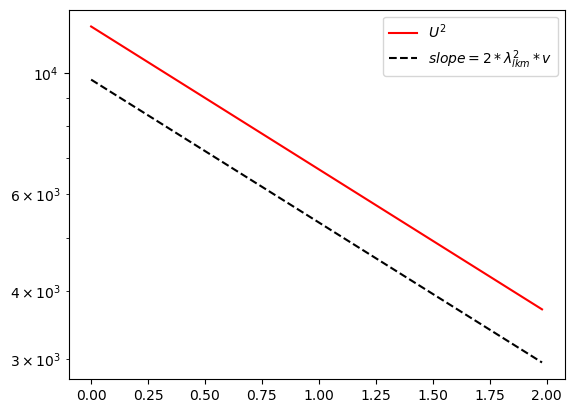

(32, 32, 32)(32, 32, 32)(32, 32, 32)
(32, 32, 32)(32, 32, 32)(32, 32, 32)


PyObject <matplotlib.legend.Legend object at 0x7f7d2da04320>

In [18]:
#Testing the decaying problem
prob  = Problem(CPU();nx = 32,Lx = 2π,
                 ν = 1/10,
                nν = 1,
                 μ = 0,
                 η = 1/10, 
                nμ = 0,
  # Timestepper and equation options
                dt = 1/50,
           stepper = "RK4",
  # Float type and dealiasing
                 T = Float64)
ProblemGenerator3D!(prob,2π,32)
uu = [];
bb = [];
for i =1:100
    updatevars!(prob);
    stepforward!(prob);
    u2,b2 = GetEnergy(prob);
    push!(uu,u2);
    push!(bb,b2);
end
t = collect(0:1/50:99/50)
semilogy(t,uu,"r",label=L"U^2")
semilogy(t,exp.(-2*3*t/10)*uu[1]*0.8,"k--",label=L"slope = 2*\lambda_{lkm}^2*v");
legend()

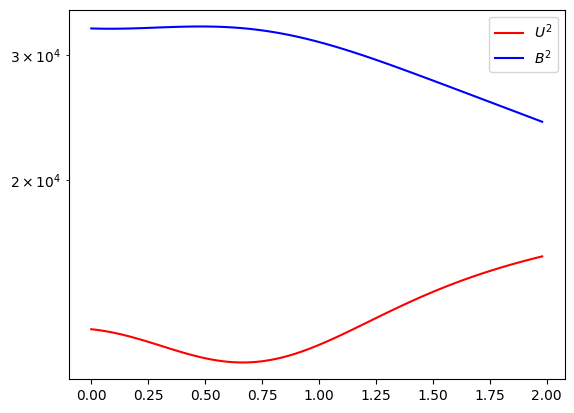

PyObject <matplotlib.legend.Legend object at 0x7f7df84f2588>

In [23]:
#Testing the decaying problem
prob  = Problem(CPU();nx = 32,Lx = 2π,
                 ν = 1/100,
                nν = 1,
                 μ = 0,
                 η = 1/100, 
                nμ = 0,
  # Timestepper and equation options
                dt = 1/50,
           stepper = "RK4",
  # Float type and dealiasing
                 T = Float64)
ProblemGenerator!(prob,2π,32)
uu = [];
bb = [];
for i =1:100
    updatevars!(prob);
    stepforward!(prob);
    u2,b2 = GetEnergy(prob);
    push!(uu,u2);
    push!(bb,b2);
end
t = collect(0:1/50:99/50)
semilogy(t,uu,"r",label=L"U^2")
semilogy(t,bb,"b",label=L"B^2")
legend()

In [32]:
n = 256
#Testing the decaying problem
prob  = Problem(CPU();nx = n,Lx = 2π,
                 ν = 1/100,
                nν = 1,
                 μ = 0,
                 η = 1/100, 
                nμ = 0,
  # Timestepper and equation options
                dt = 1/200,
           stepper = "RK4",
  # Float type and dealiasing
                 T = Float64)
ProblemGenerator!(prob,2π,n)
uu = [];
bb = [];
for i =1:1000
    updatevars!(prob);
    stepforward!(prob);
    u2,b2 = GetEnergy(prob);
    push!(uu,u2);
    push!(bb,b2);
    if i%10 == 0
       println("n cycle = ",i,"KE = ",u2/n^3,"ME = ",b2/n^3) 
    end
end


n cycle = 10KE = 0.3734903135811558ME = 0.9988862530933087
n cycle = 20KE = 0.3712427083643729ME = 0.9985081136627763
n cycle = 30KE = 0.3683351176378221ME = 0.9987795738618079
n cycle = 40KE = 0.3648821375409883ME = 0.9995780541675526
n cycle = 50KE = 0.3610281316838735ME = 1.0007512819441662
n cycle = 60KE = 0.35693902981251846ME = 1.0021254903685188
n cycle = 70KE = 0.3527934236161516ME = 1.003514336378947
n cycle = 80KE = 0.3487735579723963ME = 1.0047279385753756
n cycle = 90KE = 0.34505675835450533ME = 1.005581492276819
n cycle = 100KE = 0.34180773994814384ME = 1.0059030131493745
n cycle = 110KE = 0.33917212907414007ME = 1.00553987518335
n cycle = 120KE = 0.3372714089621075ME = 1.0043639271380482
n cycle = 130KE = 0.3361993919246026ME = 1.0022750816701573
n cycle = 140KE = 0.33602022577440865ME = 0.9992033659001238
n cycle = 150KE = 0.33676786657685664ME = 0.9951094983978079
n cycle = 160KE = 0.33844689183223936ME = 0.9899841161205706
n cycle = 170KE = 0.3410344853909141ME = 0.983

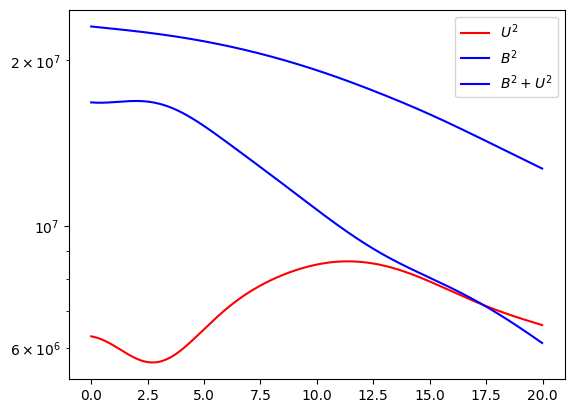

PyObject <matplotlib.legend.Legend object at 0x7fad50c18128>

In [58]:
t = collect(0:1/50:999/50)
semilogy(t,uu,"r",label=L"U^2")
semilogy(t,bb,"b",label=L"B^2")
semilogy(t,bb+uu,"b",label=L"B^2+U^2")
legend()

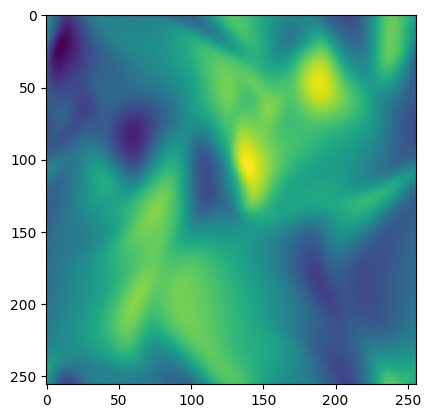

PyObject <matplotlib.image.AxesImage object at 0x7fad50ef84a8>

In [43]:
imshow(prob.vars.ux[:,:,2])

# Forcing Module
For each time step n, we can get $\phi, A $ as
$$q_n = q_{n-1}f(n)$$,
where $f(n) \in (0.98,1.02)$
This is a bit complicated, Lets start with the example at gihtub first

CalEinKf! (generic function with 1 method)